# Gamma oscillations

Here we show the implementation of gamma oscillation proposed by Xiao-Jing Wang and György Buzsáki (1996). They demonstrated that the GABA$_A$ synaptic transmission provides a suitable mechanism for synchronized gamma oscillations in a network of fast-spiking interneurons. 

Let's first import brainpy and set profiles.

In [1]:
import brainpy as bp
import brainpy.numpy as np
import bpmodels

bp.profile.set(backend='numpy', dt=0.04, numerical_method='exponential')

The network is constructed with Hodgkin–Huxley (HH) type neurons and GABA$_A$ synapses. The GABA$_A$ synapse can be directly imported with ``bpmodels.synapses.get_GABAa2``.

In [2]:
GABAa = bpmodels.synapses.get_GABAa2(g_max=0.1, E=-75., alpha = 12., beta = 0.1)

The dynamics of the HH type neurons is given by:

$$ C \frac {dV} {dt} = -(I_{Na} + I_{K} + I_L) + I(t) $$

where $I(t)$ is the injected current, the leak current $ I_L = g_L (V - E_L) $, and the transient sodium current 

$$ I_{Na} = g_{Na} m_{\infty}^3 h (V - E_{Na}) $$

where the activation variable $m$ is assumed fast and substituted by its steady-state function 
$m_{\infty} = \alpha_m / (\alpha_m + \beta_m)$.
And the inactivation variable $h$ obeys a first=order kinetics:
$$ \frac {dh} {dt} = \phi (\alpha_h (1-h) - \beta_h h)$$

$$ I_K = g_K n^4 (V - E_K) $$

where the activation variable $n$ also obeys a first=order kinetics:
$$ \frac {dn} {dt} = \phi (\alpha_n (1-n) - \beta_n n)$$

In [3]:
V_th = 0.
C = 1.0
gLeak = 0.1
ELeak = -65
gNa = 35.
ENa = 55.
gK = 9.
EK = -90.
phi = 5.0

ST = bp.types.NeuState({'V': -55., 'h': 0., 'n': 0., 'spike': 0., 'input': 0.})


@bp.integrate
def int_h(h, t, V):
    alpha = 0.07 * np.exp(-(V + 58) / 20)
    beta = 1 / (np.exp(-0.1 * (V + 28)) + 1)
    dhdt = alpha * (1 - h) - beta * h
    return phi * dhdt


@bp.integrate
def int_n(n, t, V):
    alpha = -0.01 * (V + 34) / (np.exp(-0.1 * (V + 34)) - 1)
    beta = 0.125 * np.exp(-(V + 44) / 80)
    dndt = alpha * (1 - n) - beta * n
    return phi * dndt


@bp.integrate
def int_V(V, t, h, n, Isyn):
    m_alpha = -0.1 * (V + 35) / (np.exp(-0.1 * (V + 35)) - 1)
    m_beta = 4 * np.exp(-(V + 60) / 18)
    m = m_alpha / (m_alpha + m_beta)
    INa = gNa * m ** 3 * h * (V - ENa)
    IK = gK * n ** 4 * (V - EK)
    IL = gLeak * (V - ELeak)
    dvdt = (- INa - IK - IL + Isyn) / C
    return dvdt


def update(ST, _t_):
    h = int_h(ST['h'], _t_, ST['V'])
    n = int_n(ST['n'], _t_, ST['V'])
    V = int_V(ST['V'], _t_, ST['h'], ST['n'], ST['input'])
    spike = np.logical_and(ST['V'] < V_th, V >= V_th)
    ST['spike'] = spike
    ST['V'] = V
    ST['h'] = h
    ST['n'] = n
    ST['input'] = 0.


HH = bp.NeuType('HH_neuron', requires=dict(ST=ST), steps=update)

Let's run a simulation of a network with 100 neurons with constant inputs (1 $\mu$A/cm$^2$).

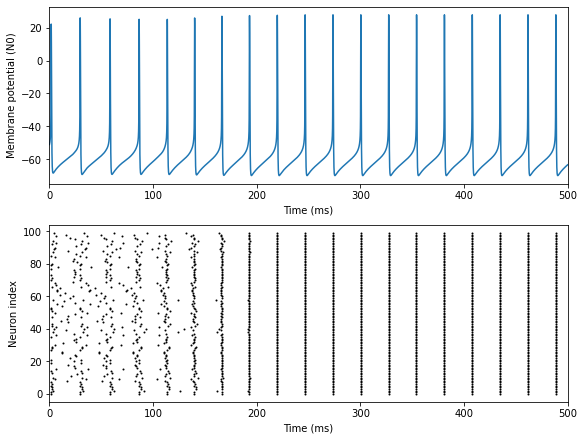

In [4]:
num = 100
v_init = -70. + np.random.random(num) * 20
h_alpha = 0.07 * np.exp(-(v_init + 58) / 20)
h_beta = 1 / (np.exp(-0.1 * (v_init + 28)) + 1)
h_init = h_alpha / (h_alpha + h_beta)
n_alpha = -0.01 * (v_init + 34) / (np.exp(-0.1 * (v_init + 34)) - 1)
n_beta = 0.125 * np.exp(-(v_init + 44) / 80)
n_init = n_alpha / (n_alpha + n_beta)

neu = bp.NeuGroup(HH, geometry=num, monitors=['spike', 'V'])
neu.ST['V'] = v_init
neu.ST['h'] = h_init
neu.ST['n'] = n_init

syn = bp.SynConn(GABAa, pre_group=neu, post_group=neu,
                 conn=bp.connect.All2All(include_self=False),
                 monitors=['s', 'g'])
syn.pars['g_max'] = 0.1 / num

net = bp.Network(neu, syn)
net.run(duration=500., inputs=[neu, 'ST.input', 1.], report=False)

fig, gs = bp.visualize.get_figure(2, 1, 3, 8)
xlim = (net.t_start - 0.1, net.t_end + 0.1)

fig.add_subplot(gs[0, 0])
bp.visualize.line_plot(net.ts, neu.mon.V, xlim=xlim, ylabel='Membrane potential (N0)')

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(net.ts, neu.mon.spike, xlim=xlim, show=True)

We can see the result of this simulation that cells starting at random and asynchronous initial conditions quickly become synchronized and their spiking times are perfectly in-phase within 5-6 oscillatory cycles.

**Reference:**

Wang, Xiao-Jing, and György Buzsáki. “Gamma oscillation by
synaptic inhibition in a hippocampal interneuronal network
model.” Journal of neuroscience 16.20 (1996): 6402-6413.